In [2]:
import numpy as np
import networkx as nx
from scipy.linalg import solve

In [6]:
W = np.array([
        [0, 2, 1, 0, 0, 3],  
        [2, 0, 4, 0, 1, 0],  
        [1, 4, 0, 5, 0, 0],  
        [0, 0, 5, 0, 3, 2],  
        [0, 1, 0, 3, 0, 4],  
        [3, 0, 0, 2, 4, 0] 
    ])
    
x_init = np.random.rand(6)

ci = [[1, 1, 1, 1, 1, 1]]
bi = [3]

In [7]:
n = len(x_init)
print(n)
ni = len(ci) if ci is not None else 0
print(ni)
ci = np.array(ci) if ni > 0 else np.zeros((0, n))
print(ci)
bi = np.array(bi) if ni > 0 else np.zeros(0)
print(bi)

6
1
[[1 1 1 1 1 1]]
[3]


In [8]:
G = -W / 4
print(G)
d = np.zeros(n)
print(d)

[[ 0.   -0.5  -0.25  0.    0.   -0.75]
 [-0.5   0.   -1.    0.   -0.25  0.  ]
 [-0.25 -1.    0.   -1.25  0.    0.  ]
 [ 0.    0.   -1.25  0.   -0.75 -0.5 ]
 [ 0.   -0.25  0.   -0.75  0.   -1.  ]
 [-0.75  0.    0.   -0.5  -1.    0.  ]]
[0. 0. 0. 0. 0. 0.]


In [9]:
W_active = np.zeros(ni, dtype=bool)
print(W_active)

[False]


In [10]:
A = ci[W_active, :] if ni > 0 else np.zeros((0, n))
print(A)
b = bi[W_active] if ni > 0 else np.zeros(0)
print(b)

[]
[]


In [11]:
K = np.block([
            [G, A.T],
            [A, np.zeros((len(A), len(A)))]
        ])
print(K)

[[ 0.   -0.5  -0.25  0.    0.   -0.75]
 [-0.5   0.   -1.    0.   -0.25  0.  ]
 [-0.25 -1.    0.   -1.25  0.    0.  ]
 [ 0.    0.   -1.25  0.   -0.75 -0.5 ]
 [ 0.   -0.25  0.   -0.75  0.   -1.  ]
 [-0.75  0.    0.   -0.5  -1.    0.  ]]


In [12]:
rhs = np.concatenate([-d, b])
print(rhs)

[-0. -0. -0. -0. -0. -0.]


In [15]:
solution = np.linalg.solve(K, rhs)
print(solution)

[-0. -0. -0.  0.  0. -0.]


In [16]:
p = solution[:n]
print(p)
lambdas = solution[n:]
print(lambdas)

[-0. -0. -0.  0.  0. -0.]
[]


In [17]:
tol = 1e-8

In [18]:
print(np.all(np.abs(p) < tol))

True


In [19]:
print(np.all(lambdas >= -tol))

True


In [22]:
import numpy as np
from scipy.optimize import minimize

def maxcut_objective(x, W):
    """
    Objective function for MaxCut: maximize sum of edge weights across the cut.
    In optimization, we minimize the negative of the objective.
    
    Args:
        x (ndarray): Binary vector representing the partition (continuous relaxation).
        W (ndarray): Weight matrix of the graph.
    Returns:
        float: Negative of the MaxCut objective value.
    """
    return -0.25 * x.T @ W @ x

def constraint_satisfaction(x, constraint_matrix, constraint_vector):
    """
    Check if constraints are satisfied for given x.
    
    Args:
        x (ndarray): Current solution.
        constraint_matrix (ndarray): Constraint matrix.
        constraint_vector (ndarray): Constraint RHS vector.
    Returns:
        ndarray: Constraint satisfaction values.
    """
    return constraint_matrix @ x - constraint_vector

def solve_constrained_maxcut(W, constraint_matrix, constraint_vector):
    """
    Solve the constrained MaxCut problem using the active set method.
    
    Args:
        W (ndarray): Weight matrix of the graph.
        constraint_matrix (ndarray): Matrix for linear constraints.
        constraint_vector (ndarray): RHS vector for linear constraints.
    
    Returns:
        dict: Solution and optimization details.
    """
    n = W.shape[0]
    
    # Initial guess (continuous relaxation to allow optimization)
    x0 = np.random.rand(n)
    
    # Define constraints for the optimizer
    constraints = [{'type': 'eq', 'fun': lambda x, A=constraint_matrix, b=constraint_vector: A @ x - b}]
    
    # Define bounds (binary decision variables relaxed to [0, 1])
    bounds = [(0, 1) for _ in range(n)]
    
    # Solve the optimization problem
    result = minimize(
        fun=maxcut_objective, 
        x0=x0, 
        args=(W,), 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    
    # Return the result and active set details
    return {
        'x_opt': np.round(result.x),  # Convert back to binary for MaxCut
        'fun_value': -result.fun,
        'success': result.success,
        'message': result.message,
        'active_set': constraints
    }

# Example usage
if __name__ == "__main__":
    # Example graph with 4 nodes and weighted adjacency matrix
    W = np.array([
        [0, 2, 3, 0],
        [2, 0, 0, 1],
        [3, 0, 0, 4],
        [0, 1, 4, 0]
    ])
    
    # Example constraints: Ax <= b
    # For simplicity, suppose we have constraints x1 + x2 <= 1 and x3 + x4 <= 1
    constraint_matrix = np.array([
        [1, 1, 0, 0],
        [0, 0, 1, 1]
    ])
    constraint_vector = np.array([1, 1])
    
    # Solve the problem
    solution = solve_constrained_maxcut(W, constraint_matrix, constraint_vector)
    print("Optimal partition:", solution['x_opt'])
    print("MaxCut value:", solution['fun_value'])
    print("Optimization success:", solution['success'])
    print("Message:", solution['message'])


Optimal partition: [1. 0. 1. 0.]
MaxCut value: 1.5312500000000002
Optimization success: True
Message: Optimization terminated successfully


Optimal partition: [1. 0. 1. 0.]
MaxCut value: 1.5312499999999998
Optimization success: True
Message: Optimization terminated successfully


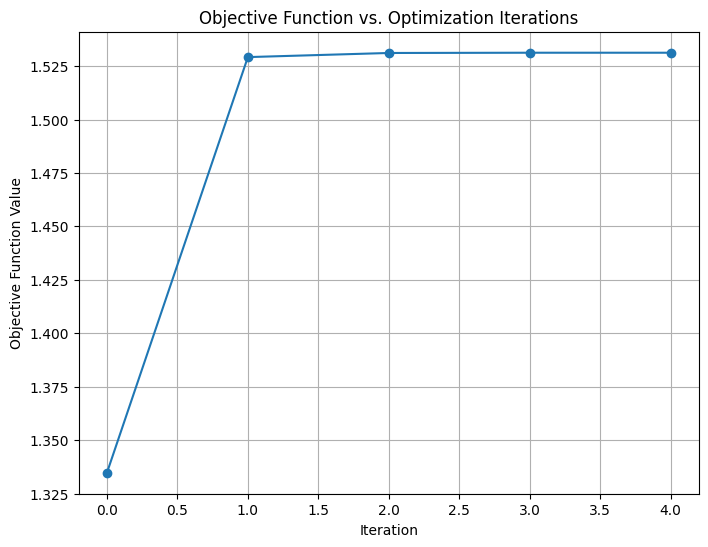

In [23]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def maxcut_objective(x, W):
    """
    Objective function for MaxCut: maximize sum of edge weights across the cut.
    In optimization, we minimize the negative of the objective.

    Args:
        x (ndarray): Binary vector representing the partition (continuous relaxation).
        W (ndarray): Weight matrix of the graph.
    Returns:
        float: Negative of the MaxCut objective value.
    """
    return -0.25 * x.T @ W @ x

def solve_constrained_maxcut(W, constraint_matrix, constraint_vector):
    """
    Solve the constrained MaxCut problem using the active set method and track objective changes.

    Args:
        W (ndarray): Weight matrix of the graph.
        constraint_matrix (ndarray): Matrix for linear constraints.
        constraint_vector (ndarray): RHS vector for linear constraints.

    Returns:
        dict: Solution, optimization details, and objective function history.
    """
    n = W.shape[0]

    # Initial guess (continuous relaxation to allow optimization)
    x0 = np.random.rand(n)

    # Define constraints for the optimizer
    constraints = [{'type': 'eq', 'fun': lambda x, A=constraint_matrix, b=constraint_vector: A @ x - b}]

    # Define bounds (binary decision variables relaxed to [0, 1])
    bounds = [(0, 1) for _ in range(n)]

    # List to store objective values at each iteration
    objective_history = []

    # Callback function to track optimization progress
    def callback(x):
        objective_history.append(-maxcut_objective(x, W))  # Record positive MaxCut value

    # Solve the optimization problem
    result = minimize(
        fun=maxcut_objective, 
        x0=x0, 
        args=(W,), 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints,
        callback=callback
    )

    # Return the result and optimization details
    return {
        'x_opt': np.round(result.x),  # Convert back to binary for MaxCut
        'fun_value': -result.fun,
        'success': result.success,
        'message': result.message,
        'active_set': constraints,
        'objective_history': objective_history
    }

def plot_objective_history(history):
    """
    Plot the objective function values over optimization iterations.

    Args:
        history (list): List of objective function values at each iteration.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history, marker='o')
    plt.title('Objective Function vs. Optimization Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.grid()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example graph with 4 nodes and weighted adjacency matrix
    W = np.array([
        [0, 2, 3, 0],
        [2, 0, 0, 1],
        [3, 0, 0, 4],
        [0, 1, 4, 0]
    ])

    # Example constraints: Ax <= b
    # For simplicity, suppose we have constraints x1 + x2 <= 1 and x3 + x4 <= 1
    constraint_matrix = np.array([
        [1, 1, 0, 0],
        [0, 0, 1, 1]
    ])
    constraint_vector = np.array([1, 1])

    # Solve the problem
    solution = solve_constrained_maxcut(W, constraint_matrix, constraint_vector)

    print("Optimal partition:", solution['x_opt'])
    print("MaxCut value:", solution['fun_value'])
    print("Optimization success:", solution['success'])
    print("Message:", solution['message'])

    # Plot the objective function history
    plot_objective_history(solution['objective_history'])

Optimal partition: [1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.]
MaxCut value: 88.0000000014818
Optimization success: True
Message: Optimization terminated successfully


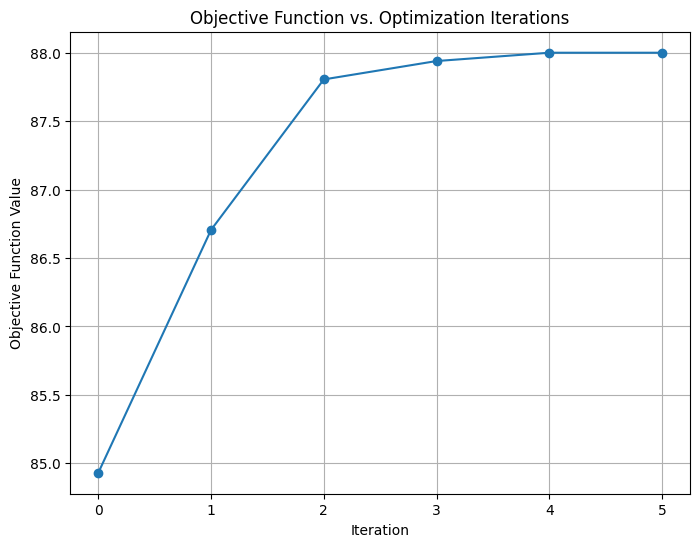

In [24]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def maxcut_objective(x, W):
    """
    Objective function for MaxCut: maximize sum of edge weights across the cut.
    In optimization, we minimize the negative of the objective.

    Args:
        x (ndarray): Binary vector representing the partition (continuous relaxation).
        W (ndarray): Weight matrix of the graph.
    Returns:
        float: Negative of the MaxCut objective value.
    """
    return -0.25 * x.T @ W @ x

def solve_constrained_maxcut(W, constraint_matrix, constraint_vector):
    """
    Solve the constrained MaxCut problem using the active set method and track objective changes.

    Args:
        W (ndarray): Weight matrix of the graph.
        constraint_matrix (ndarray): Matrix for linear constraints.
        constraint_vector (ndarray): RHS vector for linear constraints.

    Returns:
        dict: Solution, optimization details, and objective function history.
    """
    n = W.shape[0]

    # Initial guess (continuous relaxation to allow optimization)
    x0 = np.random.rand(n)

    # Define constraints for the optimizer
    constraints = [{'type': 'eq', 'fun': lambda x, A=constraint_matrix, b=constraint_vector: A @ x - b}]

    # Define bounds (binary decision variables relaxed to [0, 1])
    bounds = [(0, 1) for _ in range(n)]

    # List to store objective values at each iteration
    objective_history = []

    # Callback function to track optimization progress
    def callback(x):
        objective_history.append(-maxcut_objective(x, W))  # Record positive MaxCut value

    # Solve the optimization problem
    result = minimize(
        fun=maxcut_objective, 
        x0=x0, 
        args=(W,), 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints,
        callback=callback
    )

    # Return the result and optimization details
    return {
        'x_opt': np.round(result.x),  # Convert back to binary for MaxCut
        'fun_value': -result.fun,
        'success': result.success,
        'message': result.message,
        'active_set': constraints,
        'objective_history': objective_history
    }

def plot_objective_history(history):
    """
    Plot the objective function values over optimization iterations.

    Args:
        history (list): List of objective function values at each iteration.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history, marker='o')
    plt.title('Objective Function vs. Optimization Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.grid()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example graph with 16 nodes and weighted adjacency matrix
    np.random.seed(42)  # For reproducibility
    num_nodes = 16
    W = np.random.randint(0, 10, size=(num_nodes, num_nodes))
    W = (W + W.T) / 2  # Ensure the matrix is symmetric

    # Example constraints: sum of first half of nodes <= 4, second half <= 4
    constraint_matrix = np.zeros((2, num_nodes))
    constraint_matrix[0, :num_nodes // 2] = 1
    constraint_matrix[1, num_nodes // 2:] = 1
    constraint_vector = np.array([4, 4])

    # Solve the problem
    solution = solve_constrained_maxcut(W, constraint_matrix, constraint_vector)

    print("Optimal partition:", solution['x_opt'])
    print("MaxCut value:", solution['fun_value'])
    print("Optimization success:", solution['success'])
    print("Message:", solution['message'])

    # Plot the objective function history
    plot_objective_history(solution['objective_history'])
